### Prodcut Recommender System

Objective: 

To Build a recommender system using Amazon's Home and Kitchen reviews dataset and analyzing the performance metrics of the same

In [4]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.model_selection import train_test_split
from sklearn import neighbors
import matplotlib.pyplot as plt

%matplotlib inline

#### Convert the Reviews and Kitchen Json file to a dataframe

In [5]:
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Home_and_Kitchen_5.json.gz')

#### Snapshot of data

In [7]:
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,APYOBQE6M18AA,0615391206,Martin Schwartz,"[0, 0]",My daughter wanted this book and the price on ...,5.0,Best Price,1382140800,"10 19, 2013"
1,A1JVQTAGHYOL7F,0615391206,Michelle Dinh,"[0, 0]",I bought this zoku quick pop for my daughterr ...,5.0,zoku,1403049600,"06 18, 2014"
2,A3UPYGJKZ0XTU4,0615391206,mirasreviews,"[26, 27]",There is no shortage of pop recipes available ...,4.0,"Excels at Sweet Dessert Pops, but Falls Short ...",1367712000,"05 5, 2013"
3,A2MHCTX43MIMDZ,0615391206,"M. Johnson ""Tea Lover""","[14, 18]",This book is a must have if you get a Zoku (wh...,5.0,Creative Combos,1312416000,"08 4, 2011"
4,AHAI85T5C2DH3,0615391206,PugLover,"[0, 0]",This cookbook is great. I have really enjoyed...,4.0,A must own if you own the Zoku maker...,1402099200,"06 7, 2014"


In [9]:
df.shape

(551682, 9)

From the above we can say that the dataset has 551682 rows and 9 columns of information.

### Step2: Preparing data for KNN modeling

#### A) Modifying the helpful column

In [12]:
# Make new two columns out of 'helpful' column
df[['helpfulfirstelement', 'helpfulsecondelement']] = pd.DataFrame(df.helpful.values.tolist(), index = df.index)

In [13]:
df.drop('helpful', axis = 1, inplace = True)

In [14]:
df.shape

(551682, 10)

Here for the ease of analysis I plan to consider only the prodcuts with more than 100 product reviews for further analysis and modeling

In [16]:
reviews_count = df.groupby('asin').count().reset_index()

In [17]:
reviews_count.head(5)

,asin,reviewerID,reviewerName,reviewText,overall,summary,unixReviewTime,reviewTime,helpfulfirstelement,helpfulsecondelement
0,0615391206,11,11,11,11,11,11,11,11,11
1,0689027818,5,5,5,5,5,5,5,5,5
2,0912696591,93,93,93,93,93,93,93,93,93
3,1223070743,8,8,8,8,8,8,8,8,8
4,1567120709,16,16,16,16,16,16,16,16,16


In [18]:
reviews_count.shape

(28237, 10)

In [19]:
df_merged = pd.merge(df, reviews_count, on = 'asin', how = 'right')

In [45]:
df_merged.head(5)

,reviewerID_x,asin,reviewerName_x,reviewText_x,overall_review,summary_review,unixReviewTime_x,reviewTime_x,helpfulfirstelement_x,helpfulsecondelement_x,reviews_count,reviewerName_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,helpfulfirstelement_y,helpfulsecondelement_y
42570,A3S6PMCM0ZLFIK,B00006JSUA,Karen,I have used my skillet a number of times now. ...,5.0,I love my skillet!,1369353600,"05 24, 2013",0,0,1064,1064,1064,1064,1064,1064,1064,1064,1064
43044,A1PB1BJSULOG4L,B00006JSUA,USTVMAN,"This skillet from Lodge is truly ""pre-seasoned...",5.0,Wonderful Product,1321920000,"11 22, 2011",0,1,1064,1064,1064,1064,1064,1064,1064,1064,1064
43050,A1L2UFXTPRR6SR,B00006JSUA,"Vanessa M. Smith ""snowtoes""",My husband likes to fry bacon and morel mushro...,5.0,Works well on glasstop Stove,1388620800,"01 2, 2014",1,1,1064,1064,1064,1064,1064,1064,1064,1064,1064
43049,A3VQ9SGVA672NW,B00006JSUA,VA Mom,I am ready to ditch my all-clad non-stick pans...,5.0,Amazed!,1321056000,"11 12, 2011",2,2,1064,1064,1064,1064,1064,1064,1064,1064,1064
43048,A39H72H8NPM0R,B00006JSUA,Valuegal,"I got this because I need more iron, and I eat...",2.0,Not as seasoned as it needs to be for eggs,1281312000,"08 9, 2010",3,7,1064,1064,1064,1064,1064,1064,1064,1064,1064


In [21]:
df_merged.rename(columns={'reviewerID_y':'reviews_count', 'overall_x':'overall_review', 'summary_x':'summary_review'}, inplace=True)


In [22]:
df_final = df_merged[['asin', 'summary_review', 'overall_review', 'reviews_count']]

In [23]:
df_merged = df_merged.sort_values(by = 'reviews_count', ascending = False)

In [32]:
# select the products with more than 50 reviews
df_count = df_merged[df_merged.reviews_count > 50]

In [33]:
df_count.shape

(211402, 19)

In [34]:
df_review_mean = df.groupby('asin').mean().reset_index()

In [35]:
df_review_mean.head(5)

,asin,overall,unixReviewTime,helpfulfirstelement,helpfulsecondelement
0,0615391206,4.454545,1.364429e+09,8.181818,9.363636
1,0689027818,5.000000,1.216253e+09,3.600000,3.800000
2,0912696591,4.548387,1.346279e+09,1.688172,1.817204
3,1223070743,4.250000,1.375024e+09,0.000000,0.000000
4,1567120709,4.062500,1.324523e+09,2.250000,2.562500


#### Step 03: Aggregating the reviews based on asin

In [37]:
df_summary_review = pd.DataFrame(df_count.groupby('asin')['summary_review'].apply(list).reset_index())

In [47]:
df_summary_review.head(10)

,asin,summary_review
0,0912696591,"[Good refresher, great book for beginners, Nee..."
1,B00000JGRP,"[Mighty Mouse, Always have been happy with it ..."
2,B00000JGRT,"[cute and easy!, Paddle broke within 2 months,..."
3,B00002N5Z9,"[Too big, loud, powerful, lets bugs through fo..."
4,B00002N602,"[My Pot, Pressure Cooker, Great product, Very ..."
5,B00002N8CX,"[Great Vac for the money, CHEAP, CHEAP, CHEAP!..."
6,B00002N8CZ,"[Perfect little vacuum, Works well for small j..."
7,B00002NC6F,"[It turns the beater bar, perfect, Extra parts..."
8,B00002ND67,"[Alot of air movement, fits nicely in the wind..."
9,B00004OCIP,"[Sharp, Better than my mother's!, Best so far,..."


In [52]:
df_model = pd.merge(df_summary_review, df_review_mean, on = 'asin', how = 'inner')[['asin', 'summary_review', 'overall']]

In [54]:
df_model.head(5)

,asin,summary_review,overall
0,0912696591,"[Good refresher, great book for beginners, Nee...",4.548387
1,B00000JGRP,"[Mighty Mouse, Always have been happy with it ...",3.948052
2,B00000JGRT,"[cute and easy!, Paddle broke within 2 months,...",4.473934
3,B00002N5Z9,"[Too big, loud, powerful, lets bugs through fo...",4.176471
4,B00002N602,"[My Pot, Pressure Cooker, Great product, Very ...",4.563107


#### Step 04: Text processing for modeling:

In [56]:
def text_process(text):
    text = text.lower()
    text = re.sub('[^a-z]+', ' ', text).strip()
    return text

In [60]:
df_model['clean_summary_review'] = df_model['summary_review'].apply(' '.join).apply(lambda x: text_process(x)).copy(deep=True)

In [68]:
df_model['clean_summary_review'].head(5)

0    good refresher great book for beginners needed...
1    mighty mouse always have been happy with it wa...
2    cute and easy paddle broke within months omg t...
3    too big loud powerful lets bugs through for my...
4    my pot pressure cooker great product very good...
Name: clean_summary_review, dtype: object

In [69]:
df_model.shape

(2066, 4)

In [72]:
df_model_data=df_model.drop_duplicates(['overall'], keep ='last')

In [73]:
df_model_data.shape

(1569, 4)

In [74]:
df_model_data.head(5)

,asin,summary_review,overall,clean_summary_review
0,0912696591,"[Good refresher, great book for beginners, Nee...",4.548387,good refresher great book for beginners needed...
1,B00000JGRP,"[Mighty Mouse, Always have been happy with it ...",3.948052,mighty mouse always have been happy with it wa...
2,B00000JGRT,"[cute and easy!, Paddle broke within 2 months,...",4.473934,cute and easy paddle broke within months omg t...
4,B00002N602,"[My Pot, Pressure Cooker, Great product, Very ...",4.563107,my pot pressure cooker great product very good...
5,B00002N8CX,"[Great Vac for the money, CHEAP, CHEAP, CHEAP!...",4.284768,great vac for the money cheap cheap cheap grea...


In [ ]:
df_model_data = df_model_data.reset_index()


In [140]:
len(df_model_data['asin'].unique())*.80


1255.2

### Step 05: TFIDF model feature extraction from clean_summary_review column:

In [80]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2))
X = tfidf.fit_transform(df_model_data['clean_summary_review'])

In [82]:
X.shape

(1569, 235987)

In [84]:
X_reviews = pd.DataFrame(X.A, columns = tfidf.get_feature_names()).astype(int)

In [87]:
X_reviews_array = np.array(X_reviews)

In [88]:
X_reviews_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [90]:
split_percent = 0.8
split_size = np.floor(split_percent * X_reviews.shape[0]).astype(int)
split_size

1255

In [91]:
X_train = X_reviews_array[:split_size]
X_test = X_reviews_array[split_size:]

In [93]:
len(X_train)

1255

#### Step 06:Applying KNN model to find out three nearest prodcuts:

In [96]:
nearest_neighbors = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(X_train)

In [97]:
dist, index = nearest_neighbors.kneighbors(X_train)

Applying KNN model to find out three nearest prodcuts:
To find the three nearest neighbors, I am going to use NearestNeighbors algorithm.

In [98]:
for i in range(0, X_test.shape[0]):
    test_neighbors = nearest_neighbors.kneighbors([X_test[i]])
    related_product_indices = test_neighbors[1]
    first_nearest_product = [prod[0] for prod in related_product_indices]
    first_nearest_product = str(first_nearest_product).strip('[]')
    first_nearest_product = int(first_nearest_product)
    second_nearest_product = [prod[1] for prod in related_product_indices]
    second_nearest_product = str(second_nearest_product).strip('[]')
    second_nearest_product = int(second_nearest_product)
    third_nearest_product = [prod[2] for prod in related_product_indices]
    third_nearest_product = str(third_nearest_product).strip('[]')
    third_nearest_product = int(third_nearest_product)
    
    try:
        if i<4:
            print('Based on product reviews of ', df_model_data['asin'][X_train.shape[0] + i], ' the average rating is ', 
          df_model_data['overall'][X_train.shape[0] + i])
            print('The 1st recommended product is ', df_model_data['asin'][first_nearest_product], ' the average rating is ',
         df_model_data['overall'][first_nearest_product])
            print('The 2nd recommended product is ', df_model_data['asin'][second_nearest_product], ' the average rating is ',
         df_model_data['overall'][second_nearest_product])
            print('The 3rd recommended product is ', df_model_data['asin'][third_nearest_product], ' the average rating is ',
         df_model_data['overall'][third_nearest_product])
            print('-------------------------------------------------------------------------------------------')
    except:
        pass

Based on product reviews of  B005SI8YZC  the average rating is  3.8656716417910446
The 1st recommended product is  B0009NZ6JS  the average rating is  4.587301587301587
The 2nd recommended product is  B00004X13D  the average rating is  4.482558139534884
The 3rd recommended product is  B0000950Q4  the average rating is  3.9130434782608696
-------------------------------------------------------------------------------------------
Based on product reviews of  B005SPEV66  the average rating is  4.322033898305085
The 1st recommended product is  B0009NZ6JS  the average rating is  4.587301587301587
The 2nd recommended product is  B00004X13D  the average rating is  4.482558139534884
The 3rd recommended product is  B0000950Q4  the average rating is  3.9130434782608696
-------------------------------------------------------------------------------------------
Based on product reviews of  B005TOVVSC  the average rating is  4.516666666666667
The 1st recommended product is  B0009NZ6JS  the average r

#### Step 07: Predictive Modelling using knn Classifier 
for classifying the test data as 0,1 based on learning from training data

In [155]:
y_train = df_model_data['overall'][:X_train.shape[0]].astype(int)
y_test = df_model_data['overall'][X_train.shape[0]:].astype(int)

In [161]:
knnclassifier = neighbors.KNeighborsClassifier(n_neighbors=5, weights='distance')
knnclassifier.fit(X_train, y_train)
knnclassifier_predictions = knnclassifier.predict(X_test)

In [163]:
print(accuracy_score(y_test, knnclassifier_predictions))
print(mean_squared_error(y_test, knnclassifier_predictions))


0.8949044585987261
0.10509554140127389


#### Step 08: Analysis based on Visualization
Wordcloud for each review group

In [164]:
review_text_for_overall = df.groupby('overall')['summary'].apply(list).reset_index()

In [165]:
review_text_for_overall

,overall,summary
0,1.0,"[Waste of money, Sprelling Only, It doesn't do..."
1,2.0,[Okay but you can figure it out yourself witho...
2,3.0,"[Good for what it's worth, Okay, Disappointed ..."
3,4.0,"[Excels at Sweet Dessert Pops, but Falls Short..."
4,5.0,"[Best Price, zoku, Creative Combos, Love it, B..."


In [166]:
review_text_for_overall['clean_summary'] = review_text_for_overall['summary'].apply(' '.join).apply(lambda x: text_process(x))

In [167]:
review_text_for_overall

,overall,summary,clean_summary
0,1.0,"[Waste of money, Sprelling Only, It doesn't do...",waste of money sprelling only it doesn t do mu...
1,2.0,[Okay but you can figure it out yourself witho...,okay but you can figure it out yourself withou...
2,3.0,"[Good for what it's worth, Okay, Disappointed ...",good for what it s worth okay disappointed aga...
3,4.0,"[Excels at Sweet Dessert Pops, but Falls Short...",excels at sweet dessert pops but falls short o...
4,5.0,"[Best Price, zoku, Creative Combos, Love it, B...",best price zoku creative combos love it beauti...


In [162]:
stop_words = set(STOPWORDS)

def wordcloud_plot(txt_dat, title = None):
    wordcloud = WordCloud(background_color='white', stopwords=stop_words, max_words=300, max_font_size=30, 
        scale=3, random_state=1).generate(str(txt_dat))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

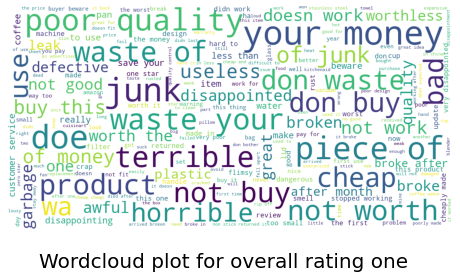

In [168]:
wordcloud_plot(review_text_for_overall['clean_summary'][0], title = 'Wordcloud plot for overall rating one')

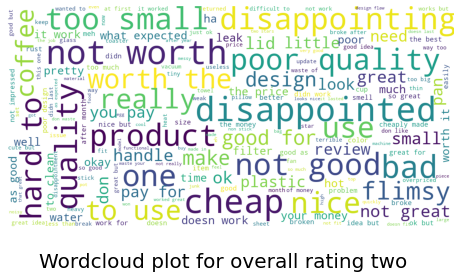

In [170]:
wordcloud_plot(review_text_for_overall['clean_summary'][1], title = 'Wordcloud plot for overall rating two')

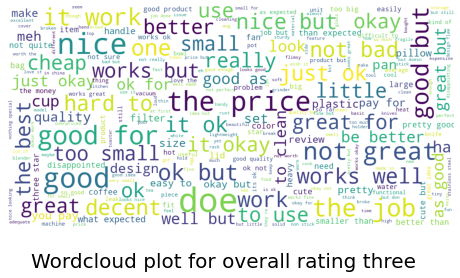

In [171]:
wordcloud_plot(review_text_for_overall['clean_summary'][2], title = 'Wordcloud plot for overall rating three')

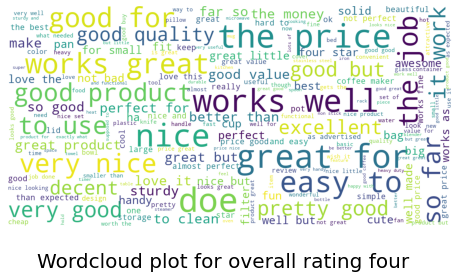

In [172]:
wordcloud_plot(review_text_for_overall['clean_summary'][3], title = 'Wordcloud plot for overall rating four')

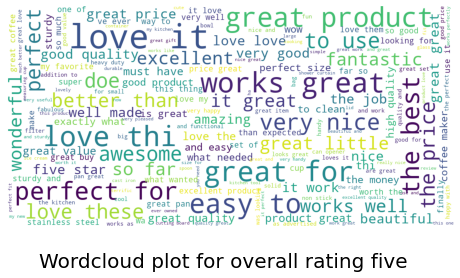

In [173]:
wordcloud_plot(review_text_for_overall['clean_summary'][4], title = 'Wordcloud plot for overall rating five')

#### Conclusion:

Hence, here we have successfully created a Product recommender system  based on product reviews for Kitchen and Appliances dataset for Amazon using 
TF-IDF Vectrizer & Nearest Neighbour Algorithm. 
